David Fleming 

For the rest, see the .param file

Contains basic code for anaylsis, plotting to be used later with my disks.

In [1]:
%matplotlib inline
#Imports required to run

import pynbody
SimArray = pynbody.array.SimArray
from matplotlib.pylab import *
import matplotlib.pylab as plt
import pynbody.plot.sph as sph
import numpy as np
from scipy import interpolate

#Tell code where my diskpy distribution is
import os
sys.path.append('/astro/users/dflemin3/Desktop/diskpy')
sys.path.append('/astro/users/dflemin3/Desktop')

#Import diskpy and my modules from ICgen submodule
import diskpy
from diskpy.ICgen import *
from diskplot import *

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,8)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 20.0

In [2]:
#Change directory to where the data is
cwd = '/astro/users/dflemin3/Desktop/sims/kepler38Long'
os.chdir(cwd)

In [3]:
#Load Snapshot 
s = pynbody.load('k38_snap.std')

#Center on barycenter
diskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
s['pos'] -= diskCom

Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  k38_snap.std
TipsySnap: loading data from main file


snapshot = pynbody.new(star=2)
for key in s.stars.keys():
    snapshot.stars[key] = s.stars[key]

snapshot.write(fmt = pynbody.tipsy.TipsySnap, filename = "onlyStars.std")


#Look at general system parameters

In [4]:
#Make sure I have 2 stars in there with correct pos/vel:
print s.stars[0]['pos']
print s.stars[1]['pos']

print s.stars[0]['vel']
print s.stars[1]['vel']

print s.stars[0]['mass']
print s.stars[1]['mass']

#Print current units
print s.stars[0]['pos'].units
print s.stars[0]['vel'].units

[[  2.73758998e-02  -2.16260473e-06  -4.13119845e-07]]
[[ -1.04364018e-01  -2.16260473e-06  -4.13119845e-07]]
[[-0.        0.658243  0.      ]]
[[ 0.        -2.5087254 -0.       ]]
[ 0.949]
[ 0.249]
4.85e-09 kpc
2.98e+01 km s**-1


In [5]:
print np.sum(s.gas['mass'])
print s.gas['mass'].units

0.00383060303477
Msol


In [6]:
print len(s.stars)
print len(s.gas)

2
100000


In [7]:
#Calculate system parameters
x1 = s.stars[0]['pos']
x2 = s.stars[1]['pos']
v1 = s.stars[0]['vel']
v2 = s.stars[1]['vel']
m1 = s.stars[0]['mass']
m2 = s.stars[1]['mass']

ef = AddBinary.calcEcc(x1, x2, v1, v2, m1, m2)
af = AddBinary.calcSemi(x1, x2, v1, v2, m1, m2)
ifin = AddBinary.calcInc(x1, x2, v1, v2)
gf = len(s.g)
mf = s.stars['mass']

print "eccentricity =",ef
print "semimajor axis =",af
print "Inclination =", ifin
print "mass =",mf
print "gas particles =",gf

eccentricity = [ 0.10324994]
semimajor axis = [ 0.14690818]
Inclination = [ 0.]
mass = [ 0.949  0.249]
gas particles = 100000


In [8]:
#Check CoM
print "Binary center of mass = {0}".format(AddBinary.calcCOM(m1,m2,x1,x2))
sysCom = binaryUtils.computeCOM(s.stars,s.gas)
diskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=False,gasFlag=True,cutoff=6)
print "Current entire system center of mass = {0}".format(sysCom)
print "Magnitude of system center of mass = {0}".format(np.sqrt(AddBinary.dotProduct(sysCom,sysCom)))
print "Disk center of mass = %.3lf" % np.sqrt(AddBinary.dotProduct(diskCom,diskCom))
vcom = binaryUtils.computeVelocityCOM(s,cutoff=0.4,starFlag=True,gasFlag=True)

Binary center of mass = [[ -5.76917131e-06  -2.16260473e-06  -4.13119845e-07]]
Current entire system center of mass = [[  2.20668383e-18  -2.00159121e-19  -1.93816050e-21]]
Magnitude of system center of mass = [  2.21574388e-18]
Disk center of mass = 0.002


SimSnap: deriving array rxy


In [9]:
r, rBinEdges = binaryUtils.calcDiskRadialBins(s,0.25,3.0,50)
orbElems = binaryUtils.orbElemsVsRadius(s,rBinEdges,average=True)
#precession = binaryUtils.diskPrecession(s,r)
"""
plt.plot(r,2.0*np.pi/precession[0,:],color='blue',label=r'$\omega$ Precession Rate')
plt.plot(r,2.0*np.pi/precession[1,:],color='red',label=r'$\Omega$ Precession Rate')
plt.axhline(y=0.0, xmin=0., xmax = 1, linewidth=2, color='k',linestyle='--')
plt.xlim(r.min(),r.max())
plt.xlabel("r [AU]")
plt.ylabel("Precession Period [yr]")
plt.title("Rand Init Low Ecc Precession")
plt.legend(loc='lower left')
#plt.savefig("randInitLowEccPrecession.pdf")
"""

'\nplt.plot(r,2.0*np.pi/precession[0,:],color=\'blue\',label=r\'$\\omega$ Precession Rate\')\nplt.plot(r,2.0*np.pi/precession[1,:],color=\'red\',label=r\'$\\Omega$ Precession Rate\')\nplt.axhline(y=0.0, xmin=0., xmax = 1, linewidth=2, color=\'k\',linestyle=\'--\')\nplt.xlim(r.min(),r.max())\nplt.xlabel("r [AU]")\nplt.ylabel("Precession Period [yr]")\nplt.title("Rand Init Low Ecc Precession")\nplt.legend(loc=\'lower left\')\n#plt.savefig("randInitLowEccPrecession.pdf")\n'

In [10]:
print binaryUtils.diskAverage(s,r_out=3.0,bins=50,avgFlag=True)

[  5.76629021e-03   1.66280412e+00   1.79979171e+00   1.79745411e+02
   1.80214591e+02   1.79962385e+02]


#Examine disk orbital element radial profiles

In [11]:
x1, x2 = s.stars['pos']
m1, m2 = s.stars[0]['mass'], s.stars[1]['mass']
v1, v2 = s.stars['vel']
m_disk = np.sum(s.gas['mass'])
x = x1-x2
v = v1-v2
X = [x,v]
test = binary.Binary(X,m1,m2,'cartesian')
print test

(0.103249944157,[ 0.14690818],0.0,0.0,0.0,0.0), mass: ([ 0.949],[ 0.249])


/astro/users/dflemin3/Desktop/diskpy/diskpy/ICgen/AddBinary.py:513: RuntimeWarning: invalid value encountered in divide
  Omega = np.arccos(dotProduct(i, n) / magN)


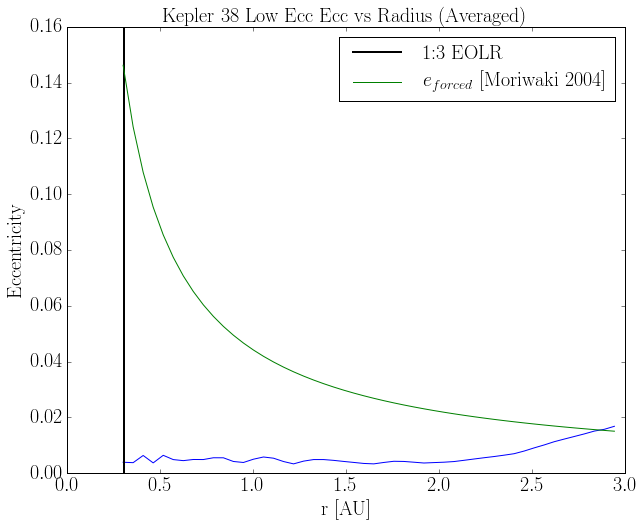

In [12]:
plt.plot(r,orbElems[0,:])
plt.xlabel('r [AU]')
plt.ylabel('Eccentricity')
plt.title("Kepler 38 Low Ecc Ecc vs Radius (Averaged)")

#Plot lines of interest
loc = 2.08*0.1469
ecc_f = binaryUtils.forcedEccentricity(test,r)*2
plt.axvline(x=loc, ymin=-1, ymax = 1, linewidth=2, color='black',label="1:3 EOLR")
plt.plot(r,ecc_f,color='green',label="$e_{forced}$ [Moriwaki 2004]")

plt.legend()
#plt.savefig("k38EccVsRadius.pdf")

#Find inner disk edge
Following the prescription of Artymowics+1994, define the gap radius for a circumbinary disk to be at the disk edge position where the surface density is half of the maximum value in the disk.  In that paper, the gap size was studied for various binary eccentricities and mass ratios.  For Kepler 38, the mass ratio is 0.263 ~ 0.3 and the eccentricity is ~0.1.  These values correspond to a gap size of $r = 2.35 \pm 0.15$ times the binary semimajor axis.  For Kepler 38 whose a = 0.1469, one would expect to find after ~ 100 binary orbits a gap radius of ~0.34 au.  This gap formation occurs due to the tidal action of the binary system on the disk (and accretion where applicable).

The initial conditions of Artymowics+1994:

N_gas: ~ $10^4$
Disk Properties: axisymmetric; initialized with Keplerian velocities; $\Sigma \sim 1/r$; introduced binary into initially smooth disk (similar to my initialization).  For a binary with mass parameter $\mu = 0.3$ and eccentricity = 0.1, they found a gap at $r \approx 2.3a$ which is outside the 3:1 orbital period commensurability (Arty+1994 pg. 662).  


Note: In Kley+2014, they found that after ~2000yr of evolution, the inner edge of the disk to be $r \approx 0.45 au$ which corresponds to roughly $3a_{bin}$ which they claim is in good agreement with the results of Artymowics+1994.  The problem here is that Kley+2014 studied Kepler 38 where the mass ratio is about 0.3 and the eccentricity about 0.1.  The result that $r_{gap} \approx 3a_{bin}$ corresponds to a mass ratio of 0.3 and an eccentricity of 0.5 which does not hold for Kepler 38.


Below, I bin the disk surface density into radial bins and compute the radius at which the half maximum surface density occurs as described above.

In [13]:
#Create profile.  Note: Choose nbins to be the same number of n points ICgen-Binary used to initial generate disk
bins = 500

p = pynbody.analysis.profile.Profile(s,max=' au',min='0.01 au',type='log',nbins=bins)
pg = pynbody.analysis.profile.Profile(s.gas,nbins=bins,max='6 au')

#Get arrays for surface density sigma, radius r
sigma = pg['density']
radius = pg['rbins']

#Select subset of radial points within radius at which sigma = sigmaMax/2 (inner edge of disk)
max_index = np.argmax(sigma)
mask = (radius < radius[max_index])
sigma = sigma[mask]
radius = radius[mask]

#Find location of surface density maximum and look at radius r < r_max to find radius where surface density = max/2.0
halfMax = pg['density'].max()/2.0
#print "Half Max Surface Density = {0} {1}".format(halfMax,pg['density'].units)
    
crit_r = binaryUtils.find_crit_radius(radius,sigma,halfMax,bins)
    
print "Inner gap edge radius = {0}".format(crit_r)

Profile: density()
Profile: mass()
Inner gap edge radius = 0.240700172002


#Plot disk radial profiles

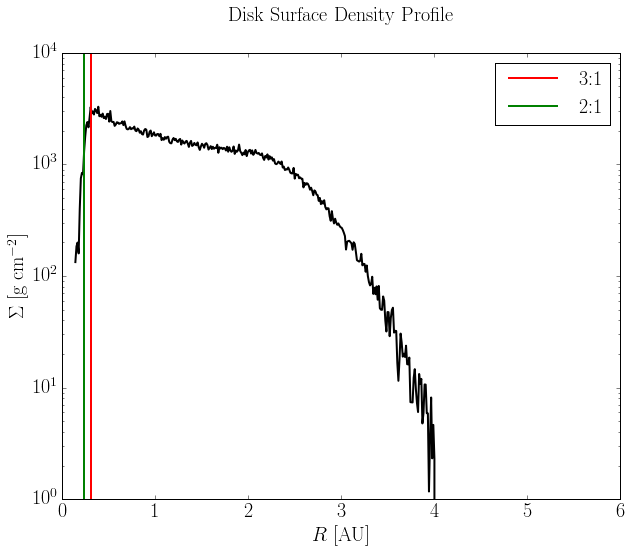

In [14]:
#Try plotting stuff
#Plot the gas surface density as a function of radius for test disk

#Now do the plotting with data derived from gas profile, pg
#In this case, tangential velocity vs. radius
plt.plot(pg['rbins'], pg['density'].in_units("g cm**-2"),'k',linewidth=2)

plt.xlabel("$R$ [AU]")
plt.ylabel(r'$\Sigma$ [g cm$^{-2}$]')
plt.yscale('log')
plt.title('Disk Surface Density Profile',y=1.06)
#plt.xscale('log') #confirm radius powerlaw relation
plt.xlim([0,6])

#Plot lines of interest
#loc = 0.4644 #Radius of Kepler-38b
loc = 2.08*test.a
loc2 = AddBinary.pToA(2*18.8,1.2)
#print float(rCrit)
plt.axvline(x=loc, ymin=-1, ymax = 1, linewidth=2, color='red',label="3:1")
plt.axvline(x=loc2, ymin=-1, ymax = 1, linewidth=2, color='green',label="2:1")

plt.legend(loc='upper right')

#Print units to confirm
#print repr(pg['rbins'].in_units('au'))
#print repr(pg['density'].in_units('g cm**-2'))

#plt.savefig("sigmaVsR.png")

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/pynbody/analysis/profile.py:407: RuntimeWarning: invalid value encountered in double_scalars
  result[i] = (name_array*mass_array).sum()/self['mass'][i]


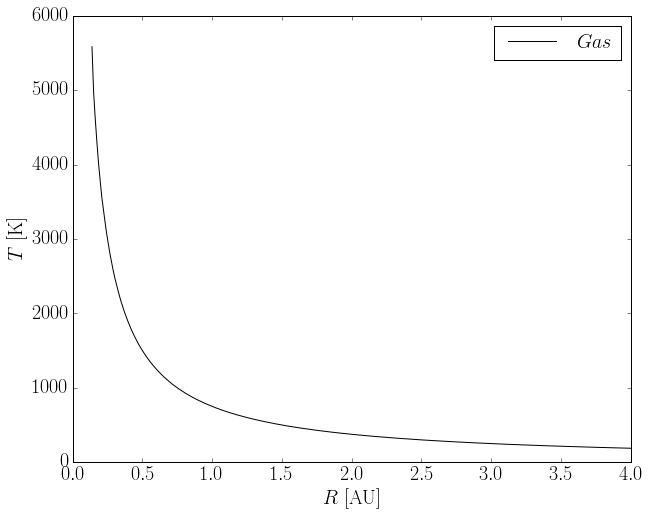

In [15]:
#Try plotting temperature profile of gas in plane of disk
#T vs. radius
plt.plot(pg['rbins'], pg['temp'],'k', label = '$Gas$')
plt.legend()
#plt.semilogy()
#plt.semilogx()
plt.xlabel("$R$ [AU]")
plt.ylabel("$T$ [K]")
plt.show()

SimSnap: deriving array p
SimSnap: deriving array u
SimSnap: deriving array mu


(0.2, 1)

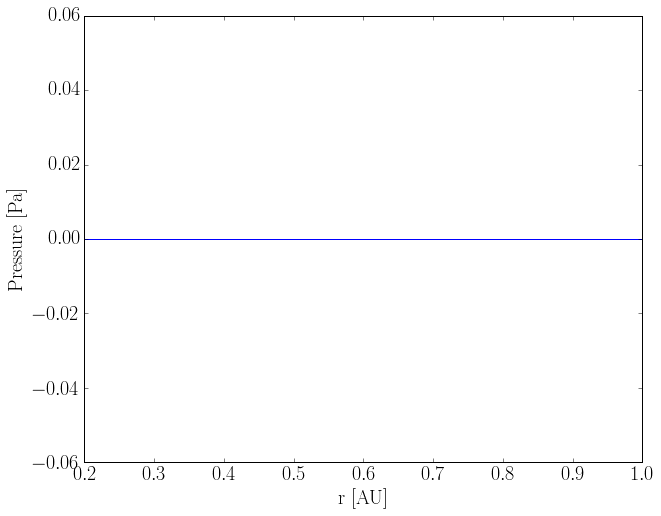

In [16]:
plt.plot(pg['rbins'],pg['p'].in_units('Pa'))
plt.xlabel("r [AU]")
plt.ylabel('Pressure [Pa]')
plt.xlim(0.2,1)

#Plot 2D Heatmaps (Histograms) of Density, temperature, and pressure

In [17]:
pynbody.plot.gas.rho_T(s, rho_units='g cm**-3')
plt.title('2D Histogram of Density vs Temperature',y=1.02)

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/pynbody/plot/generic.py:109: RuntimeWarning: divide by zero encountered in log10
  x_range = [np.log10(np.min(xo)), np.log10(np.max(xo))]
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/pynbody/plot/generic.py:115: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(xo)
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/core/function_base.py:100: RuntimeWarning: invalid value encountered in double_scalars
  delta = stop - start
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/numpy/lib/function_base.py:414: RuntimeWarning: invalid value encountered in less_equal
  if np.any(np.asarray(dedges[i]) <= 0):


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
pynbody.plot.generic.hist2d(s.gas['rho'].in_units("g cm**-3"),s.gas['p'].in_units('Pa'),xlogrange=True,ylogrange=True);
plt.title('2D Histogram of Density vs. Pressure',y=1.02)

In [ ]:
pynbody.plot.generic.hist2d(s.gas['temp'],s.gas['p'].in_units('Pa'),xlogrange=True,ylogrange=True,
                           x_range=(2,3.8),y_range=(-5,3));
plt.title('2D Histogram of Temperature vs. Pressure',y=1.02)
plt.xlim(2,3.8)
plt.ylim(-5,3)

In [ ]:
#Create nice color plot of temp as function of radius


#pynbody.analysis.angmom.faceon(s1.g)#create an image of gas density integrated
#down the line of site (z axis) of width 50 Au
sph.image(s.g,qty="rho",units="g cm^-2",width=1,cmap="Greys")

#Plot circle representing theoretical location of gap...should occur ~ 100 orbits
list_radians = [0]
 
# from degrees to radians, the 0 is already included so
# we don't make the universe collapse by dividing by zero.
for i in range(0,360):
    float_div = 180.0/(i+1)
    list_radians.append(pi/float_div)
     
# list of coordinates for each point
list_x2_axis = []
list_y2_axis = []

ai = 0.1469
r = 2.3*ai #Inner gap edge predicted by Artimowicz+1994 for binary similar to Kepler 38
#r = 0.25
# calculate coordinates
# and append to above list
for a in list_radians:
    list_x2_axis.append(r*cos(a))
    list_y2_axis.append(r*sin(a))
    
#plot the coordinates
plt.plot(list_x2_axis,list_y2_axis,c='r')
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])

In [ ]:
#Create verticle profiles

#Create verticle gas profile object
p_vert = pynbody.analysis.profile.VerticalProfile(s.gas, '0 au', '20 au', '25 au') #(range_min,range_max,max)

#Now plot density vs distance
#Confirm density units are correct
p_vert['density'].convert_units('Msol au**-3')
print p_vert['density'].units
print p_vert['rbins'].units
plt.plot(p_vert['rbins'], p_vert['density'],'k', hold=False)
plt.xlabel('$z$ [Au]')
plt.ylabel(r'$\rho_{\star}$ [M$_{\odot}$ Au$^{-3}$]')
plt.yscale('log')

In [ ]:
#Plot temperature vs. distance from plane
#Looks terrible since data is for small number of particles
plt.plot(p_vert['rbins'], p_vert['temp'],'k', hold=False)
plt.xlabel('$z$ [Au]'); plt.ylabel('$T$ [K]')

In [ ]:
#Plot velocity vectors
f, axs = plt.subplots(1,1,figsize=(8,8))

#create a simple slice showing the gas temperature, with velocity vectors overlaid
sph.velocity_image(s.g, vector_color="cyan", qty="temp",width=10,cmap="YlOrRd",
                   denoise=True,approximate_fast=False, show_cbar = False)

#plt.savefig("vectors.pdf")

work_dir = '/gscratch/stf/dflemin3/k38_sims/kepler38Long'
subscript=diskpy.pychanga.hyak.pbs_script(work_dir,param='k38_snap.param',
                                          jobname='Kepler38_520yrs',backill=False,email='dflemin3@uw.edu',
                                          walltime=110)
with open('subber.sh','w') as f:
    f.write(subscript)

In [28]:
x1_gas = s.gas['pos']
x_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'au')
v1_gas = s.gas['vel']
v_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'km s**-1')
m1 = np.sum(s.s['mass'])
m2 = s.gas['mass']
gas_m = s.gas['mass'].in_units('g')

cm = binaryUtils.computeCOM(s.stars,s.gas,cutoff=3.0).in_units('au')

#Compute semimajor axis, longitude of perihelion (relative to that of bin) for ALL gas particles
gas_a = AddBinary.calcSemi(x1_gas,cm,v1_gas,v_zero,m1,m2)
gas_e = AddBinary.calcEcc(x1_gas,cm,v1_gas,v_zero,m1,m2)
gas_w = AddBinary.calcArgPeri(x1_gas,cm,v1_gas,v_zero,m1,m2) + AddBinary.calcLongOfAscNode(x1_gas,x_zero,v1_gas,v_zero)
gas_w = gas_w - (test.Omega + test.w)
gas_w[gas_w > 360] = gas_w[gas_w > 360] - 360.0
gas_w[gas_w < 0] = gas_w[gas_w < 0] + 360.0

inner = 0
outer = 10

#Filter out gas particles that aren't bound
mask = np.logical_and(gas_e < 1,gas_e > 0)
gas_a = gas_a[mask]
gas_w = gas_w[mask]
gas_e = gas_e[mask]
gas_m = gas_m[mask]

#Now Filter gas particles to within a certain distance
mask = np.logical_and(gas_a < outer,gas_a > inner)
gas_a = gas_a[mask]
gas_w = gas_w[mask]
gas_e = gas_e[mask]
gas_m = gas_m[mask]

In [29]:
m1 = s.stars[0]['mass'].in_units('g')
m2 = s.stars[1]['mass'].in_units('g')
M = m1+m2
mu = (gas_m*M/(gas_m + M)).in_units('g')

print np.sum(mu*np.sqrt(AddBinary.G*M*gas_a.in_units('cm')*(1-gas_e*gas_e)))

4.76200452526e+50


In [30]:
print np.sum(AddBinary.compute_L(gas_a, gas_e, M, gas_m))
print AddBinary.compute_L(test.a,test.e,m1,m2)
print
print np.sum(AddBinary.compute_E(gas_a,M,gas_m))
print AddBinary.compute_E(test.a,test.m1,test.m2)

4.76200460139e+50
[  7.29405251e+51]

-3.15615062221e+43
[ -1.41903421e+46]


(<matplotlib.figure.Figure at 0x7fc7440e18d0>,
 <matplotlib.colorbar.Colorbar instance at 0x7fc743fdd908>)

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


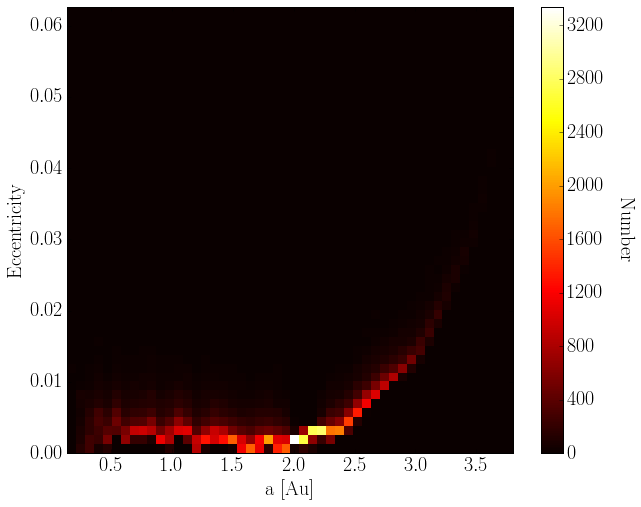

In [31]:
diskplot.plot_heatmap(gas_a,gas_e,labels=['a [Au]','Eccentricity','Number'])

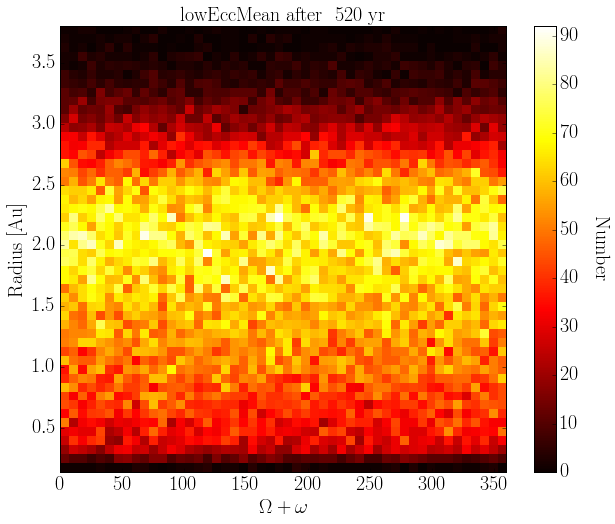

In [32]:
fig, ax, im, cbar = diskplot.plot_heatmap(gas_w,gas_a,labels=['$\Omega + \omega$','Radius [Au]','Number'],
                                    cm='hot')
ax.set_title("lowEccMean after ~520 yr")
#fig.savefig("24.09.2015OmegaVsRadiuslowEccMeanLong520yr.pdf")

In [ ]:
x1 = -1.82689837e-02  
y1 = -2.43563803e-02

print np.arctan2(y1,x1)*180./np.pi

x1 = 2.06388651e-02   
y1 = 2.23253207e-02

print np.arctan2(y1,x1)*180./np.pi

In [ ]:
print "%.2f" % (s.stars['pos'].units)